# Notebook 2: model training

In this notebook, the goal is to leverage the data in order to build a solid binary classifier and detect tomatoes. At the end, we will have a final model that can be exported and used later on for predictions. 

For the sake of the exercise, we will not conduct a complete experiment environment, with baselines, iterations, fine-tuning... mainly due to time limitation. However, at each step of the journey, we will carefully indicate what has been done, and what should be done in real life experiments, in order to get the best results out of our work.

In [61]:
import os
import sys
import json
from pathlib import Path

import pandas as pd
import numpy as np
from skimage import io
from sklearn import metrics
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from torch import optim, tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torchvision.utils import make_grid
from torchvision import models
from torchvision.transforms.functional import to_tensor

sys.path.append('..')
from src.tomatoes_dataset import TomatoesDataset
from src.predict import load_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset and dataloaders

As stated in the previous notebook, we build a `TomatoesDataset` **dataset** class in order to load our data.

**Preprocessing** steps are performed in the dataset class in order to get our data ready and optimal:

* **Resizing**: since all the images don't have the exact same size, we need to manually resize them. Instead of cropping them to 600x600, we decide to naively resize them despite of losing the aspect ratio. It is preferable since croping could make a positive image lose its tomatoes pixels and confuse the network.
* **Data augmentation**: for each tomato image, we generate a horizontal flip, a vertical flip, 90 degree rotation, -90 degree rotation. This tackles two problems:
    * **Small dataset and overfitting**: the number of tomato images is pretty small. By augmenting it, we get more data, and are less prone to overfitting. 
    * **Class imbalance**: by generating more tomato images, we augment the positive class in order to match the negative one.
* **Tensor**: at the very end, we convert our data to tensors for further processing, this also maps the [0, 255] space to [0, 1] for each pixel

In order to experiment faster with less data, we also developped an under-sampling technique, which takes a random sample of non-tomato image to match the number of positive cases. We don't use it for the final model training.

Note that each of the steps above could (and should) be subject to experiments and tuning in order to find the best preprocessing strategy.

In [62]:
DATA_PATH = Path('..') / 'data'
IMG_DIR_PATH = DATA_PATH / 'assignment_imgs'
ANNOTATIONS_PATH = DATA_PATH / 'img_annotations.json'
LABEL_MAPPING_PATH = DATA_PATH / 'label_mapping.csv'

dataset = TomatoesDataset(IMG_DIR_PATH, ANNOTATIONS_PATH, LABEL_MAPPING_PATH, sampling='over')

We obtain a dataset of 5136 images, with a 50/50 split between tomatoes and non tomatoes.

The dataset is split into a training, testing and evaluation set. The training set is used for training itself, testing for evaluating the model while training, and the evaluation set is only used for the final evaluation.

Ideally, once we start to get our candidates for the best models, we should use a **k-fold cross-validation** strategy. Cross-validation would allow to compare models robustness against multiple dataset by comparing their performance and variance. Due to long training time, we only stick to a simple training / test split with a ratio of 0.8.

We use Pytorch dataloaders to be able to easily iterate over batches. We are then given tensors of dimension $(batch\_size, 3, 600, 600)$. 

In [4]:
ratio = 0.8

# Compute sizes
train_test_size = int(len(dataset) * ratio)
eval_size = len(dataset) - train_test_size
train_size = int(train_test_size * ratio)
test_size = train_test_size - train_size


train_test_set, eval_set = random_split(dataset, [train_test_size, eval_size])
train_set, test_set = random_split(train_test_set, [train_size, test_size])

# Create the loaders in order to iterate
train_loader = DataLoader(train_set, shuffle=True, batch_size=32)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1)
eval_loader = DataLoader(eval_set, shuffle=False, batch_size=32)

## Model and optimization

### GPU

Training is done on a Nvida Tesla T4 using Cuda. Training for 30 epochs takes around 45 minutes.

### Model selection

Note that before doing the actual model selection, we should establish a naive baseline in order to refer our improvements to previous work. However, we skip this step here and compare directly potential target models.

We played with two main models:

* a home-made CNN with classic architecture similar to [LeNet](http://yann.lecun.com/exdb/lenet/), inspired from an in-class project a few years back 
* a well-known model provided by PyTorch, state-of-the-art for image classification, the [ResNet](https://pytorch.org/docs/stable/torchvision/models.html#id10)

After some basic experiments, we quickly observe facts:
* Without fine-tuning, ResNet over-performs our custom CNN by far
* Pretrained version of ResNet learns faster and better then the raw version

We then decided to not use the classic CNN and only keep playing with the pre-trained ResNet:

* For such a short-team project, it appears wise to not reinvent the wheel
* ResNet pretaining allows to quickly get good results compared to the classic CNN
* Training for 30 epochs takes approximately 45 minutes, so we can't afford many experiments

In a real-life case, we should of course experiment way further with models architectures and try many more options with hyper-parameters tuning, with careful evaluation. 

Note that we don't talk about over-fitting here since over-fitting prevention strategies are embedded in the model architecture.

In [5]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
model = model.cuda()

### Loss and optimizer

We use the [Adam](https://arxiv.org/abs/1412.6980) optimizer with a learning rate of 0.001 and the binary cross entropy loss function.

Note that we could experiment with a learning rate scheduler to update training speed when meeting a plateau for instance.

In [6]:
criterion = BCEWithLogitsLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training

We train our model by passing multiple times over the dataset with 30 epochs. 
We also collect training and testing losses and accuracies for evaluation.

In [7]:
def get_classes(batch_outputs):
    return torch.max(batch_outputs, dim=1)[1]

def accuracy(outputs, labels):
    return (get_classes(outputs) == get_classes(labels)).sum().float() / outputs.shape[0]

In [8]:
num_epochs = 30

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in tqdm(range(num_epochs), desc='Epoch'):
    model.train()

    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)
        
        train_loss += loss.item()
        train_acc += acc.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = train_acc / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    torch.save(model.state_dict(), f'../data/out/resnet_epoch_{epoch}.cp')

    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        test_acc = 0.0

        for inputs, labels in test_loader:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            test_loss += loss.item()
            test_acc += acc.item()

    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = test_acc / len(test_loader)
    
    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)

## Evaluation

We can now look at the model behavior.

In [29]:
def plot_epochs(train_values, test_values, title):
    plt.plot(train_values, label='training')
    plt.plot(test_values, label='testing')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

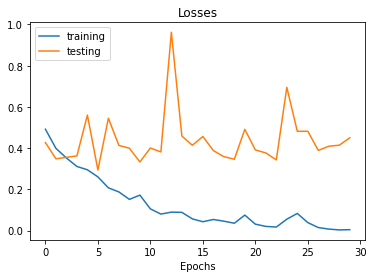

In [10]:
plot_epochs(train_losses, test_losses, 'Losses')

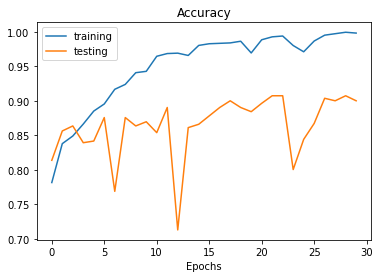

In [30]:
plot_epochs(train_accs, test_accs, 'Accuracy')

In [19]:
test_accs[21]

0.9075425790754258

From the learning curves, it seems that the model starts to be trained correctly after 15 epochs. After this time, it appears that the training loss and testing accuracy starts to plateau, which might indicate over-fitting. 

However, the testing loss is not very stable, which might indicate we would need to train even longer. After playing with the learning rate, I could not get it more stable. This would need more investigation.

It is well-known that the accuracy is not always the best metric when we talk about binary classification. It is very insightful to look at the F1-score and confusion matrix to understand the strengths and weaknesses of our model. Note that we could also compare models using ROC curves and area under the curve, but we let that as future work.

First, we load the model generated after 21 epochs and we compute the predictions on the evaluation dataset. Recall that the model has **never** seen any of this data yet.

In [23]:
model_eval = load_model('../data/out/resnet_epoch_21.cp').cuda()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in eval_loader:
        outputs = model_eval(inputs.cuda())
        all_preds.extend(get_classes(outputs).cpu().numpy().tolist())
        all_labels.extend(get_classes(labels).cpu().numpy().tolist())

Then we look at F1-score and confusion matrix.

In [24]:
metrics.f1_score(all_labels, all_preds)

0.8987929433611884

In [25]:
metrics.confusion_matrix(all_preds, all_labels)

array([[435,  47],
       [ 62, 484]])

F1-score is not horrible, but not great either, like the accuracy. 

The confusion matrix does not look aweful, even thougth false positive and false negative are not rare. We see that their number is actually quite similar. 

**In a medical context such as allergies, we might need to optimize the model to prevent false negatives.**

**There is still a lot of work to get a best-in-class model.**

Finally, let's look at an example of prediction with an image:

In [26]:
def imshow_tensor(tensor):
    plt.imshow(tensor.numpy().transpose(1, 2, 0))

True


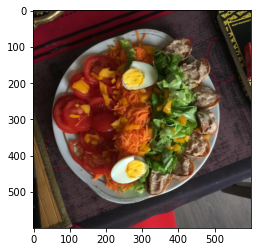

In [27]:
exp_dataset = TomatoesDataset(IMG_DIR_PATH, ANNOTATIONS_PATH, LABEL_MAPPING_PATH)

idx = 9
_, label = torch.max(model_eval(exp_dataset[idx][0].unsqueeze(0).cuda()), dim=1)
print(bool(label))
imshow_tensor(exp_dataset[idx][0])